In [4000]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from importlib import reload
import utils, VAE
reload(utils)
reload(VAE)
from utils import *
from VAE import VAE


In [4001]:
checkpoint = torch.load('VAE.pth', map_location='cpu', weights_only=False)
args = checkpoint['model_args']
vae = VAE(**args)
vae.load_state_dict(checkpoint['state_dict'])
vae.eval()

VAE(
  (encoder): Encoder(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
    (mu): Linear(in_features=32, out_features=4, bias=True)
    (logvar): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=200, bias=True)
    )
  )
)

In [4002]:
net = DeepONet([42, 42, 42], [42, 42, 42], K=2, activation='tanh')
model = Model(net, vae.decoder)
model.train(iterations=500, val_interval=10)


step       loss       r1          r2


RuntimeError: shape '[200, 50, 10, 2]' is invalid for input of size 2000000

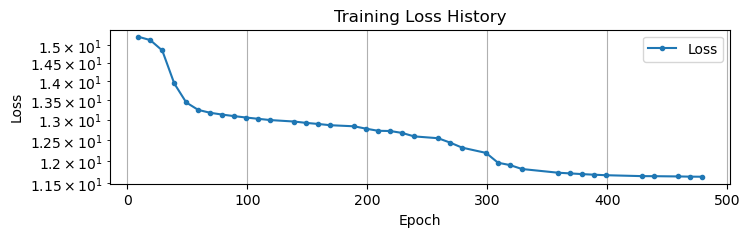

In [ ]:
model.plot_losshistory()

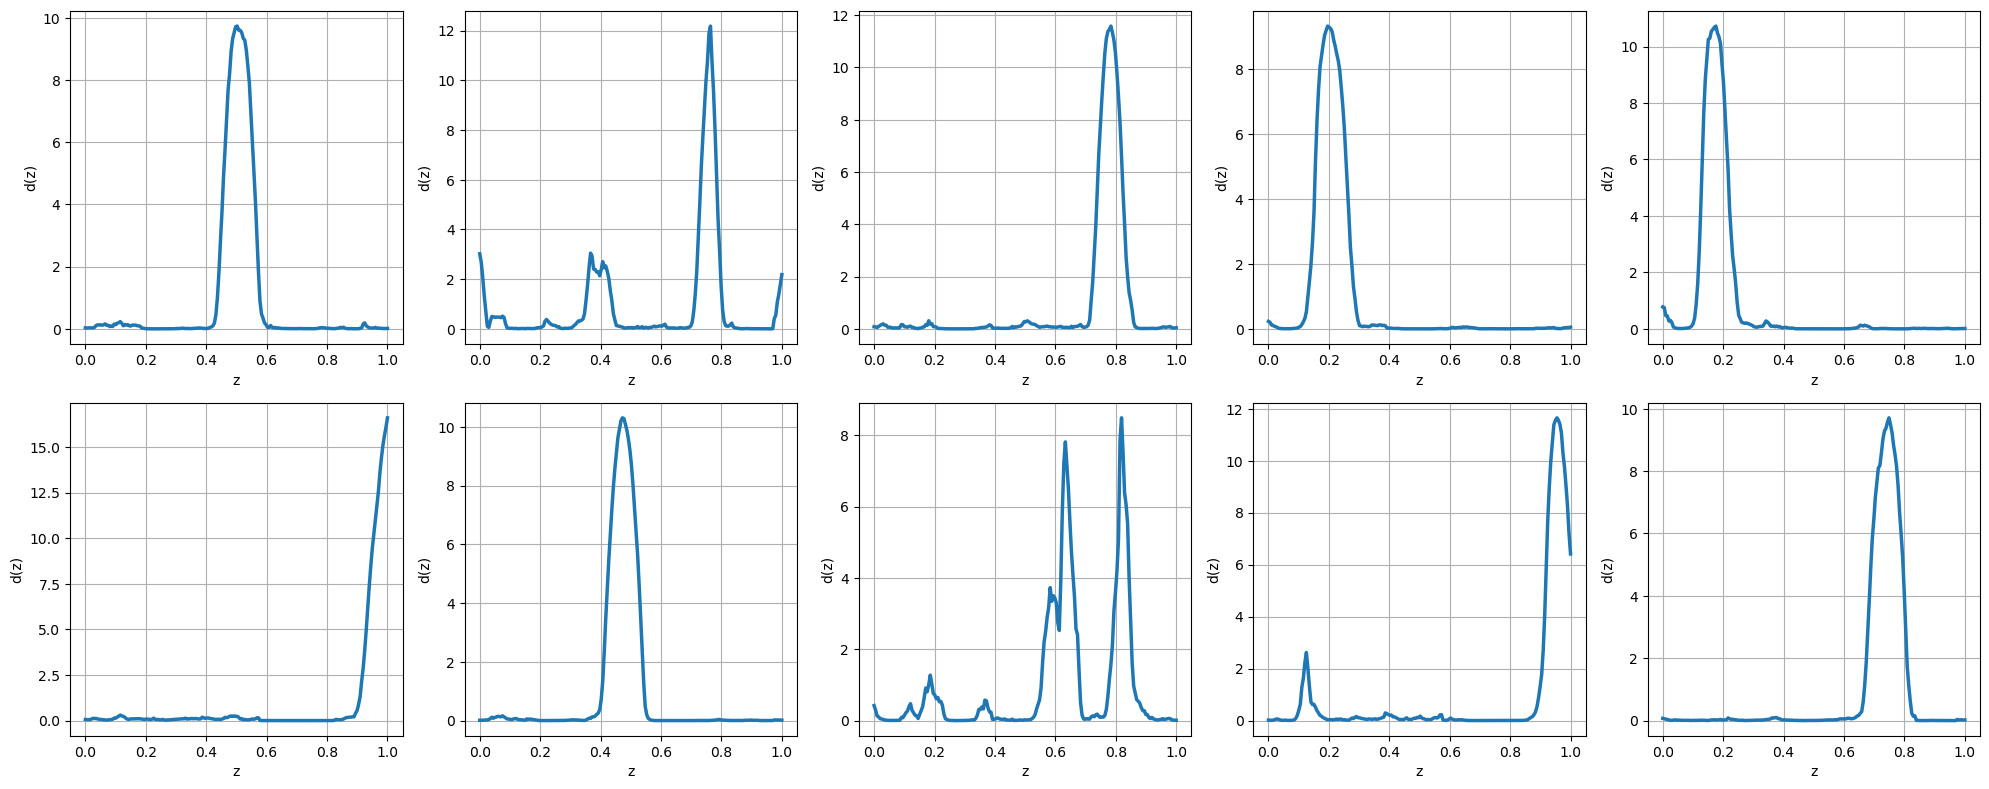

In [ ]:
torch.manual_seed(42)

grid = np.linspace(0, 1, 200)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows × 5 columns
axes = axes.flatten()

eps = torch.randn(10, 4)

n = model.X.shape[0]
X_expanded = model.X.repeat_interleave(model.Neps).unsqueeze(1)
eps_expanded = eps.repeat(n, 1)
epsX = torch.cat([X_expanded, eps_expanded], dim=1)

d = vae.decoder(eps).detach().numpy()

for j, ax in enumerate(axes):
    #ax.plot(grid, x[j,:], label=f"Sample {j+1}", linewidth=2.5)
    ax.plot(grid, d[j,:], label=f"Sample {j+1}", linewidth=2.5)
    ax.set_xlabel("z")
    ax.set_ylabel("d(z)")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
zt = torch.cartesian_prod(torch.tensor([L], dtype=torch.float32), torch.tensor(t_eval,dtype=torch.float32))
output = model.net(zt, epsX)

i = 7

ql_diff = output[0,:,:,0].detach().numpy()
p0_diff = output[0,:,:,1].detach().numpy()

print(ql_diff.shape)

#print(model.X[0,i])

(50, 10)


In [ ]:
q0 = lambda t : 1 + 0.1 * np.sin(2 * np.pi * t / 10)
pl = lambda t : 1.0 + 0.1 * np.sin(2 * np.pi * t / 10)

ys0, ysd = [], []
for i in range(10):
    sol_0 = solve(q0=q0, pl=pl, d=d[i,:], X=0)
    sol_d = solve(q0=q0, pl=pl, d=d[i,:], X=1)
    ys0.append(sol_0.y)
    ysd.append(sol_d.y)
    
y0 = np.stack(ys0)
yd = np.stack(ysd)

In [ ]:
ql0 = y0[:,Nz-1,:].T
p00 = y0[:,Nz,:].T

qld = yd[:,Nz-1,:].T
p0d = yd[:,Nz,:].T

print(ql0.shape)

(50, 10)


In [ ]:
ql_error_syn = np.abs(ql0 + ql_diff - qld).sum(0) / (Nz-1)
ql_error_org = np.abs(ql0 - qld).sum(0) / (Nz-1)
ql_norm = np.abs(qld).sum(0) / (Nz-1)

p0_error_syn = np.abs(p00 + p0_diff - p0d).sum(0) / (Nz-1)
p0_error_org = np.abs(p00 - p0d).sum(0) / (Nz-1)
p0_norm = np.abs(p0d).sum(0) / (Nz-1)



print(ql_error_syn / ql_norm)
print(p0_error_syn / p0_norm)

[0.56911463 0.48071396 0.55754813 0.56646353 0.55019535 0.54340161
 0.58333389 0.57344711 0.64482889 0.55862819]
[0.07864159 0.04696143 0.04848748 0.09671066 0.10094937 0.05204273
 0.08251432 0.05018621 0.04416883 0.05374503]


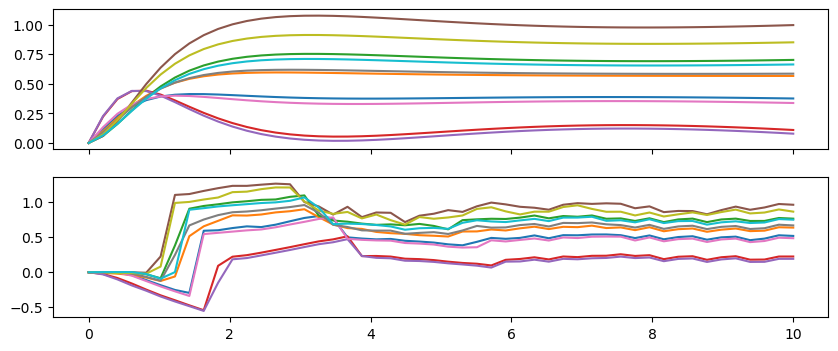

In [ ]:
i = 8


fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

# print(sol_d.y.shape)
# axs[0].plot(sol_0.t, ql0.mean(1), label='normal')
# axs[0].plot(sol_0.t, qld.mean(1), label='leaking')

# axs[1].plot(sol_0.t, p00.mean(1), label='normal')
# axs[1].plot(sol_0.t, p0d.mean(1), label='leaking')

# axs[0].plot(sol_0.t, ql0.mean(1) + ql_diff.mean(1), label='synthetic')
# axs[1].plot(sol_0.t, p00.mean(1) + p0_diff.mean(1), label='synthetic')

axs[0].plot(sol_0.t, p0_diff, label='synthetic')
axs[1].plot(sol_0.t, p0d -p00, label='synthetic')

# axs[0].legend()
# axs[1].legend()

plt.show()


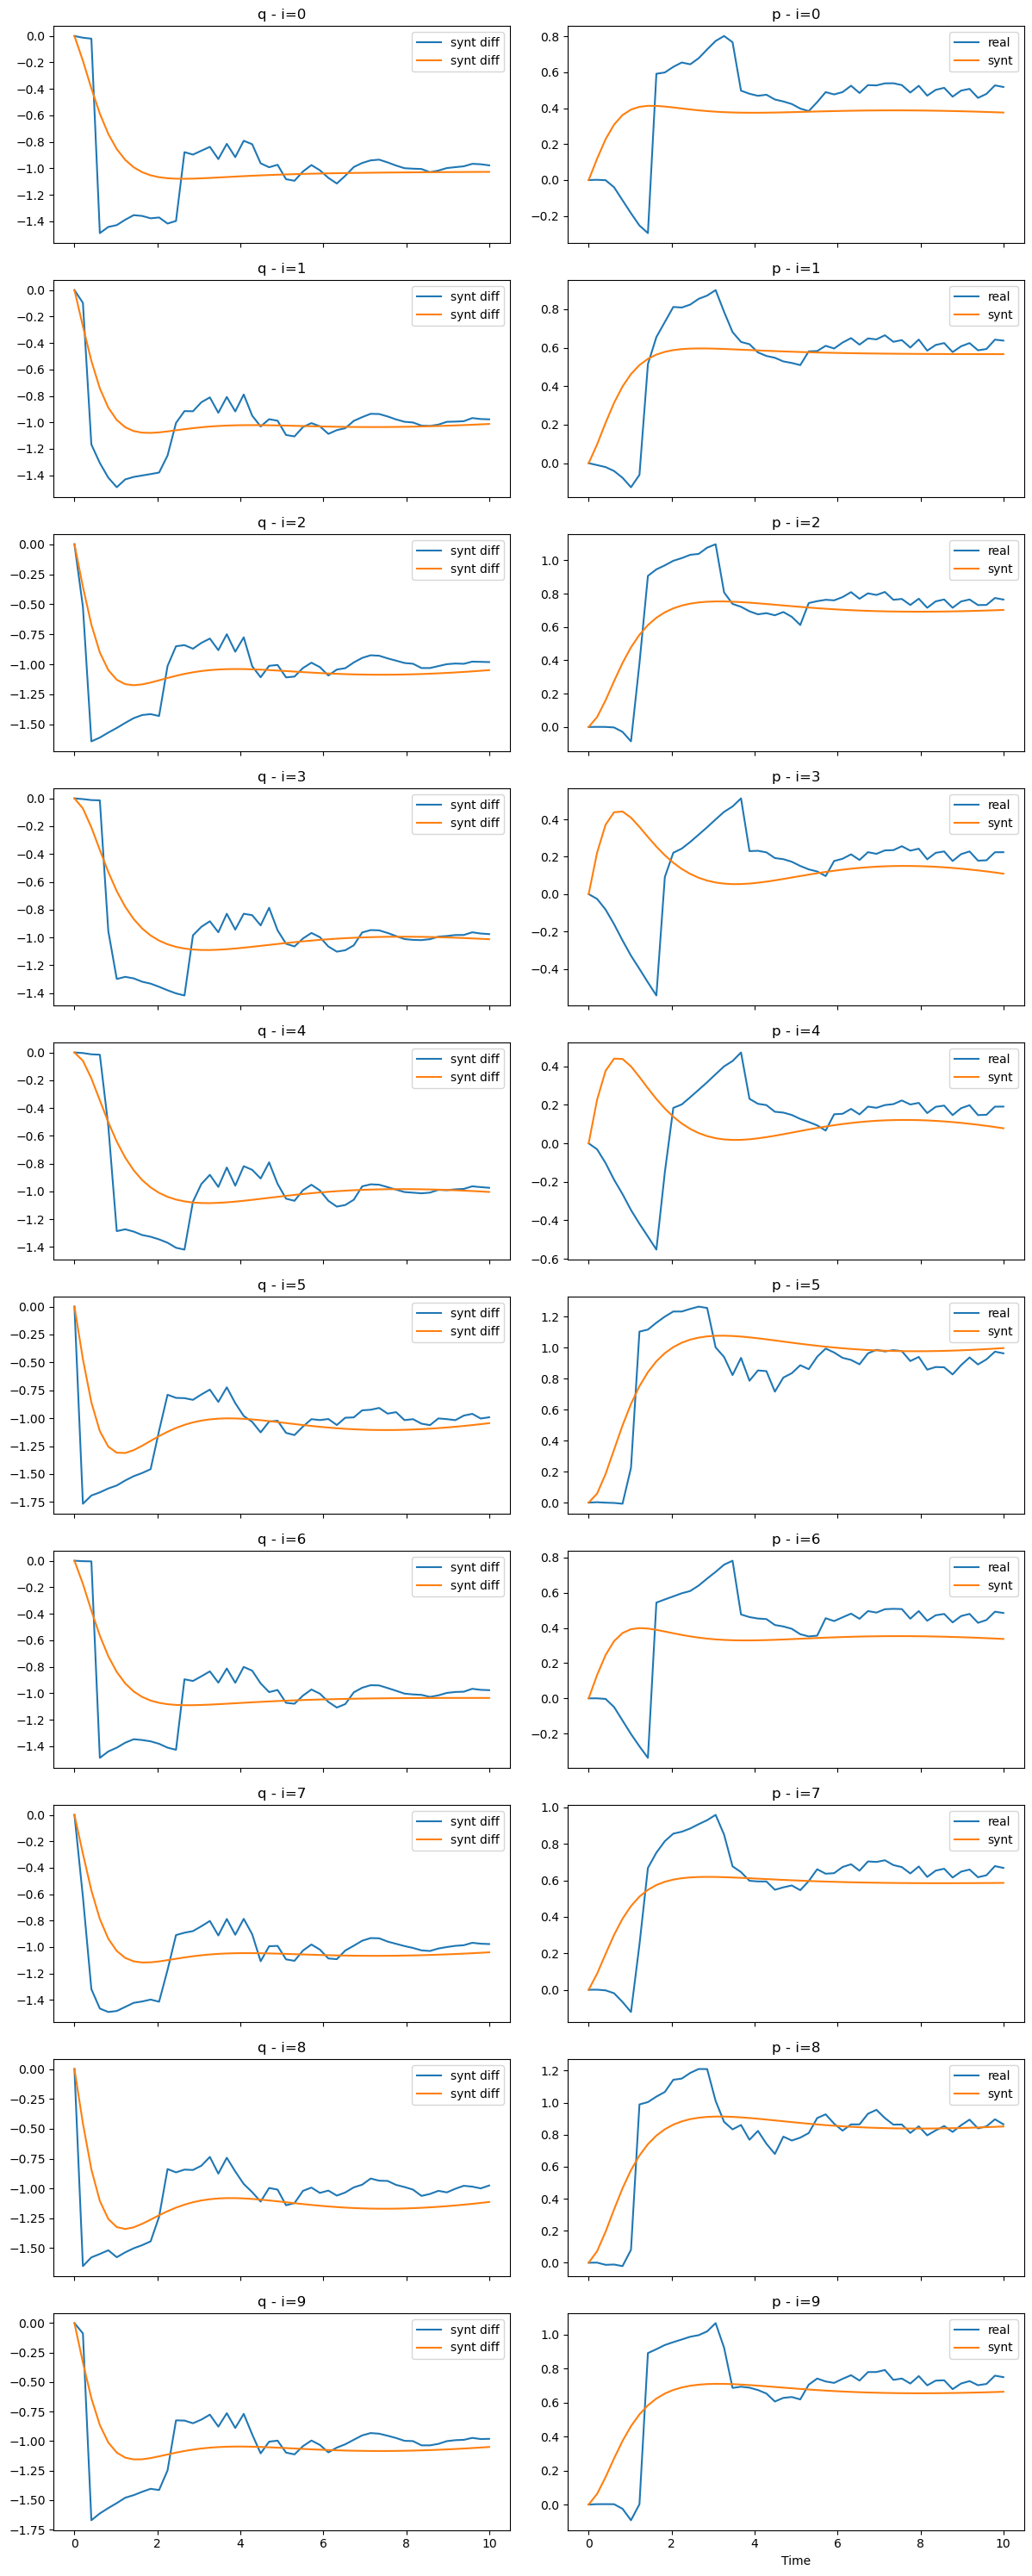

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 2, figsize=(12, 30), sharex=True)  # 10 rows, 2 columns
fig.subplots_adjust(hspace=0.4)

for i in range(10):
    ax_q = axs[i, 0]
    ax_p = axs[i, 1]
    
    #ax_q.plot(sol_0.t, ql0[:, i], label='real diff')
    ax_q.plot(sol_0.t, qld[:, i] - ql0[:, i], label='synt diff')
    ax_q.plot(sol_0.t,  ql_diff[:, i], label='synt diff')
    ax_q.set_title(f'q - i={i}')
    ax_q.legend()

    #ax_p.plot(sol_0.t, p00[:, i], label='normal')
    ax_p.plot(sol_0.t, p0d[:, i]-p00[:, i], label='real')
    ax_p.plot(sol_0.t, p0_diff[:, i], label='synt')
    ax_p.set_title(f'p - i={i}')
    ax_p.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()


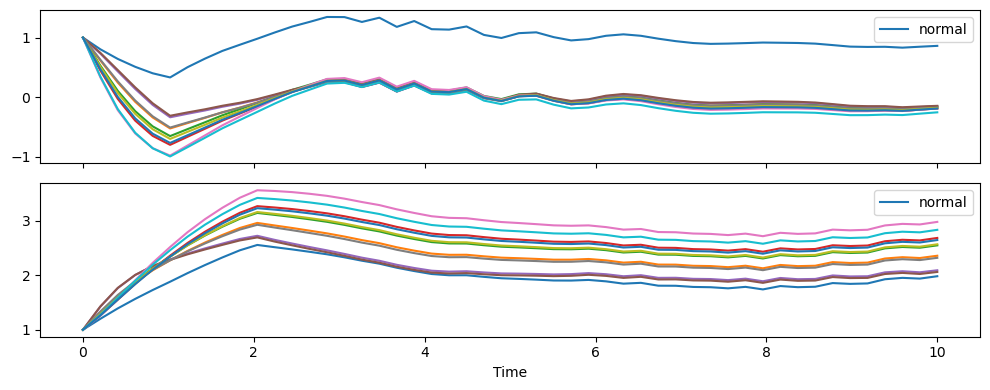

In [ ]:
import matplotlib.pyplot as plt

fig.subplots_adjust(hspace=0.4)

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)


ax[0].plot(sol_0.t, ql0[:,0], label='normal')
ax[0].plot(sol_0.t, ql0 + ql_diff)
ax[0].legend()

ax[1].plot(sol_0.t, p00[:,0], label='normal')
ax[1].plot(sol_0.t, p00 + p0_diff)
ax[1].legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()
